# Business Intelligence (WI-201) / 2023
#### Prof. Dr. Sebastian Fischer

## Übungsblatt 2: OLAP

> *Durch die Bearbeitung dieses Übungsblattes werden die Lerninhalte der Lerneinheit 2 praktisch angewendet und gefestigt. Durch pünktliche Abgabe eines vollständigen Übungsblattes werden Punkte auf die Gesamtbewertung erzielt. Das Übungsblatt ist eine Individualleistung. Gleichzeitig darf mit maximal zwei weiteren Studierenden gemeinsam die eigene Lösung besprochen werden. Sollte eine Lösung Elemente von anderen Studierenden oder Quellen beinhalten, die nicht als solche gekennzeichnet wurden, wird das Übungsblatt für alle Beteiligten mit 0 Punkten bewertet.*

In [1]:
from hilfsfunktionen import *
import pandas as pd
import numpy as np
from IPython.display import display_html
from sqlalchemy import create_engine, text
import mysql.connector
from mysql.connector import errorcode
import pymysql
import openpyxl


## Aufgabe 1: 
**OLAP orientierte Analyse direkt aus dem Star-Schema (Übungsblatt 1) mit SQL**

Wir wollen nun unser in Übungsblatt 1 erstelltes Star-Schema erneut mit SQL abfragen, um die folgenden 3 unternehmensrelevanten Fragestellungen zu beantworten

>1. Wie viel Gewinn haben die Filialen in Deutschland im Monat März gemacht?
>2. Welche Produktkategorien haben in welchen Ländern einen Verlust (negativer Gewinn) eingebracht?
>3. Denke dir eine weitere OLAP-Analyse aus. Oder nimm diese hier: Von welchen Herstellern wurde insgesamt wie viel umgesetzt?

In [2]:
mysql_usr = "Katherine" # mit eurem Nutzer ersetzen
mysql_pw = "root" # mit eurem Passwort ersetzen

connection = create_server_connection("localhost", mysql_usr, mysql_pw)
# Falls bereits eine Datenbank namens "OLAP_DB" existiert, wird sie mit diesem Befehl gelöscht:
create_database_query = "DROP DATABASE IF EXISTS OLAP_DB;"
create_database(connection, create_database_query)

# Erstellen der Datenbank "OLAP_DB"
create_database_query = "CREATE DATABASE OLAP_DB;"
create_database(connection, create_database_query)

# Befüllen der OLAP_DB mit Daten aus bereitgestelltem SQL script
file = open("data/db/OLAP_DB_schema+data.sql", 'r')
olap_db_sql_script_string = file.read()
file.close()
connection = create_db_connection("localhost", mysql_usr, mysql_pw, "OLAP_DB")
execute_query(connection, olap_db_sql_script_string)

MySQL Database connection successful
Database created successfully
Database created successfully
MySQL Database connection successful
Query successful


### Beispiel

In [3]:
connection = pymysql.connect(host='localhost',
                                user=mysql_usr,
                                password=mysql_pw,
                                db='OLAP_DB')
query = '''
    SELECT Faktentabelle_Marketing_Vertrieb.`Umsatz Ist`, \
        Faktentabelle_Marketing_Vertrieb.`Umsatz Soll`, \
            Standortestammdaten.LandBez, \
                Faktentabelle_Marketing_Vertrieb.Waehrung FROM \
                    Standortestammdaten JOIN Faktentabelle_Marketing_Vertrieb \
                        ON Standortestammdaten.FilialeID = Faktentabelle_Marketing_Vertrieb.FilialeID
                        '''
df_umsaetze_land_waehrung = pd.read_sql(query, con=connection)
df_umsaetze_land_waehrung = df_umsaetze_land_waehrung[
                                df_umsaetze_land_waehrung["Umsatz Ist"] > 0
                                ].groupby(["Waehrung", "LandBez"]).sum().round(1)
df_umsaetze_land_waehrung


C:\Users\kuhle\AppData\Local\Temp\ipykernel_12404\4239652865.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_umsaetze_land_waehrung = pd.read_sql(query, con=connection)


Umsatz Ist  Umsatz Soll
Waehrung LandBez                                 
CAD      Kanada           62781969.5   63277852.9
CHF      Schweiz          39048975.3   38695908.9
DKK      Dänemark        325200977.3  328575322.8
EUR      Belgien          20394028.5   20565187.1
         Deutschland     265841023.9  266301148.3
         Finnland         23106586.1   23077226.6
         Frankreich       21821336.6   21910183.7
         Irland           12813938.7   12912657.4
         Italien          18228291.0   18206736.1
         Spanien          30676048.2   30399151.5
         Österreich       35221093.8   35442797.1
GBP      Großbritannien   11301620.2   11341017.5
NOK      Norwegen         47821762.0   47554195.6
PLN      Polen            85469352.4   85670742.1
SEK      Schweden         98238074.2   97905560.1
USD      USA              28862592.4   28653558.5

### Aufgabe 1.1

In [4]:
# Wie viel Gewinn haben die Filialen in Deutschland im Monat März gemacht?
# Lösung Inspo Tom
query = '''
        select `filiale-bez`, landbez, monat,
        sum(gewinn) as gewinn
        from faktentabelle_marketing_vertrieb 
        natural join zeitdimension
        natural join standortestammdaten
        where monat = 'März' and landbez = 'Deutschland'
        group by `filiale-bez`, landbez, monat
        '''
df_gewinn23 = pd.read_sql(query, con=connection)
df_gewinn23

C:\Users\kuhle\AppData\Local\Temp\ipykernel_12404\4013463630.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_gewinn23 = pd.read_sql(query, con=connection)


,filiale-bez,landbez,monat,gewinn
0,Global Computer Suppliers-Berlin,Deutschland,März,1226575.56
1,Global Computer Suppliers-Frankfurt a.M.,Deutschland,März,1340588.80
2,Global Computer Suppliers-München,Deutschland,März,1421986.22
3,Global Computer Suppliers-Stuttgart,Deutschland,März,1637243.83


### Aufgabe 1.2

In [5]:
# Welche Produktkategorien haben in welchen Ländern einen Verlust (negativer Gewinn) eingebracht?
query = '''
    select s.landbez, p.produktkategorie, 
    sum(f.gewinn) as verlust
    from faktentabelle_marketing_vertrieb f
    natural join standortestammdaten s
    natural join produktstamm p
    group by s.landbez, p.produktkategorie
    having sum(f.gewinn) < 0
    '''
df_verlust23 = pd.read_sql(query, con=connection)
df_verlust23

C:\Users\kuhle\AppData\Local\Temp\ipykernel_12404\3435744118.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_verlust23 = pd.read_sql(query, con=connection)


,landbez,produktkategorie,verlust
0,Großbritannien,Tablet PC,-651972.42
1,Großbritannien,Tablet,-39642.25


### Aufgabe 1.3

In [6]:
# Welche Produkte in Großbritannien wirken sich negativ auf den Gewinn aus?

query = '''
    select ProduktID, SUM(gewinn) AS verlust
    from faktentabelle_marketing_vertrieb 
    natural join zeitdimension
    natural join standortestammdaten
    where Jahr = '2003' AND landbez = 'Großbritannien' AND gewinn < 0
    group by ProduktID
    order by verlust
    '''
df_fehlerquellen = pd.read_sql(query, con=connection)
df_fehlerquellen

C:\Users\kuhle\AppData\Local\Temp\ipykernel_12404\1249269589.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_fehlerquellen = pd.read_sql(query, con=connection)


,ProduktID,verlust
0,31,-313285.88
1,25,-254332.65
2,24,-206333.18
3,1,-197897.70
4,15,-140788.84
5,17,-122778.00
6,90,-44728.53
7,38,-43359.65
8,80,-28922.42
9,50,-5946.88


In [7]:
# Welche Produkte verursachen 80% des Verlustes der Filialen in Großbritannien?
df_fehlerquellen['aggregierter_verlust'] = df_fehlerquellen['verlust'].cumsum()
verlust_100p = df_fehlerquellen['verlust'].sum()
verlust_80p = verlust_100p*0.8
df_filtered = df_fehlerquellen.loc[df_fehlerquellen['aggregierter_verlust'] > verlust_80p]
df_filtered
# Durch z.B. entfernen der Produkte 31, 25, 24 und 1 aus dem Produktsortiment
# der Filialien in Großbritannien, können wir 80% der Verluste vermeiden.

,ProduktID,verlust,aggregierter_verlust
0,31,-313285.88,-313285.88
1,25,-254332.65,-567618.53
2,24,-206333.18,-773951.71
3,1,-197897.70,-971849.41


## Aufgabe 2: 
### Pivot Analyse (OLAP Operationen in MS Excel)

> Nutze die Pivottabellenfunktion von Excel, um die oben bereits ausgeführten OLAP-Analysen zu erzeugen. Für jede Frage soll eine Ergebnistabelle erstellt werden. Erstelle dazu jeweils ein neues Excel-Tabellenblatt, welches die Pivot-Tabelle enthält, die zur Beantwortung der Frage aus der folgenden Liste benötigt wird. Binde zusätzlich in dieses Jupyter Notebook einen Screenshot der jeweiligen Tabelle ein.

> 0. Wie hoch ist der Ist- und Soll Umsatz in jedem Land insgesamt? Ordne die Ansicht nach der Landeswährung. (das hatten wir bereits in Übungsblatt 1 und wurde hier noch mal aufgenommen, damit ihr seht, wie ein Screenshot eingebunden wird)
> 1. Wie viel Gewinn haben die Filialen in Deutschland im Monat März gemacht? 
> 2. Welche Produktkategorien haben in welchen Ländern einen Verlust (negativer Gewinn) eingebracht?
> 3. Deine eigene OLAP-Analyse oder meine Vorgabe

### Beispiel
![Beispiel](screenshots/Aufgabe2-0.jpg)

In [8]:
# alles_to_excel
query = '''
    select distinct *
    from faktentabelle_marketing_vertrieb 
    natural join zeitdimension
    natural join standortestammdaten
    natural join produktstamm
    '''
df_excel = pd.read_sql(query, con=connection)
df_excel.to_excel('uebungsblatt_2.xlsx')

C:\Users\kuhle\AppData\Local\Temp\ipykernel_12404\2768645820.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_excel = pd.read_sql(query, con=connection)


### Aufgabe 2.1
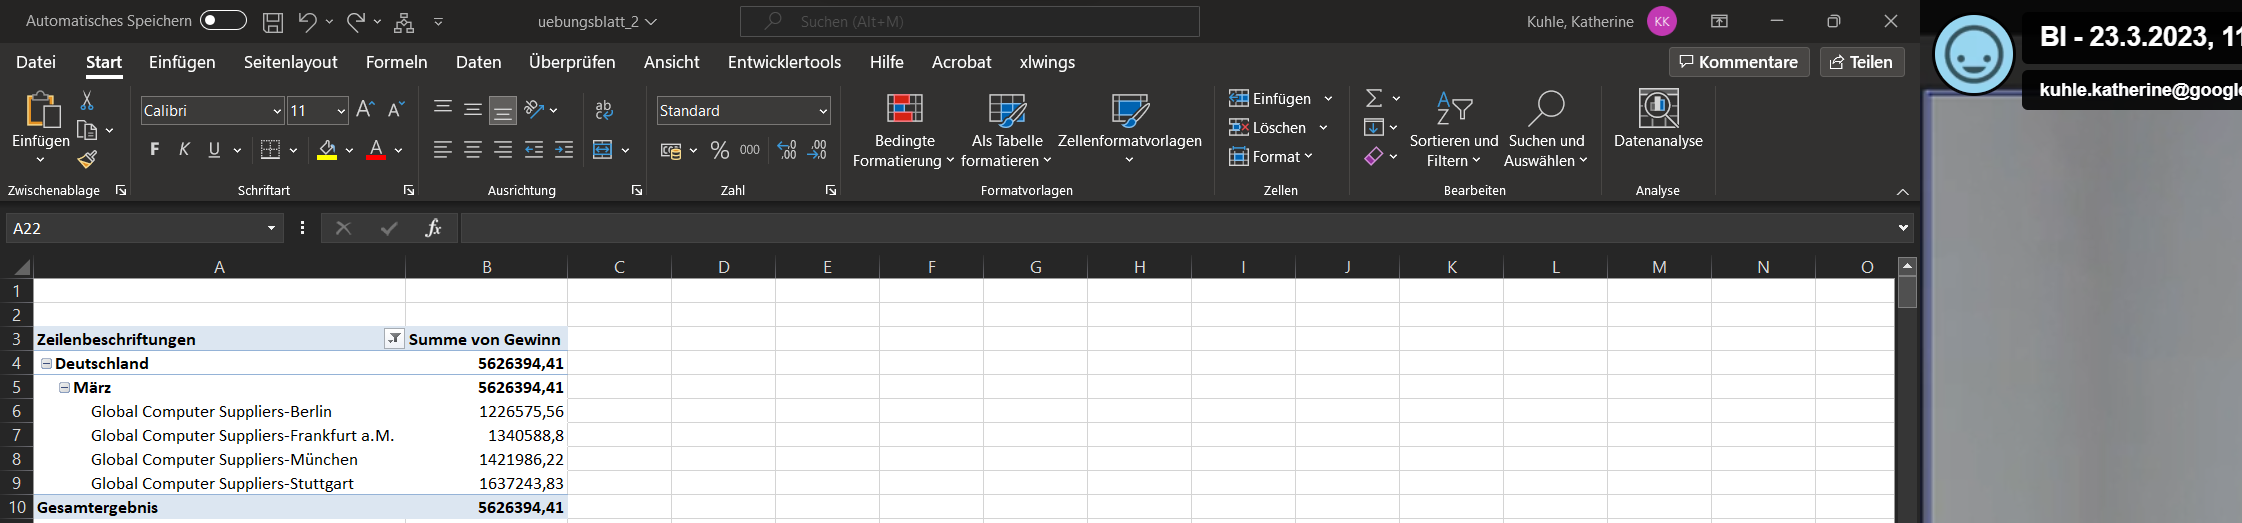

### Aufgabe 2.2
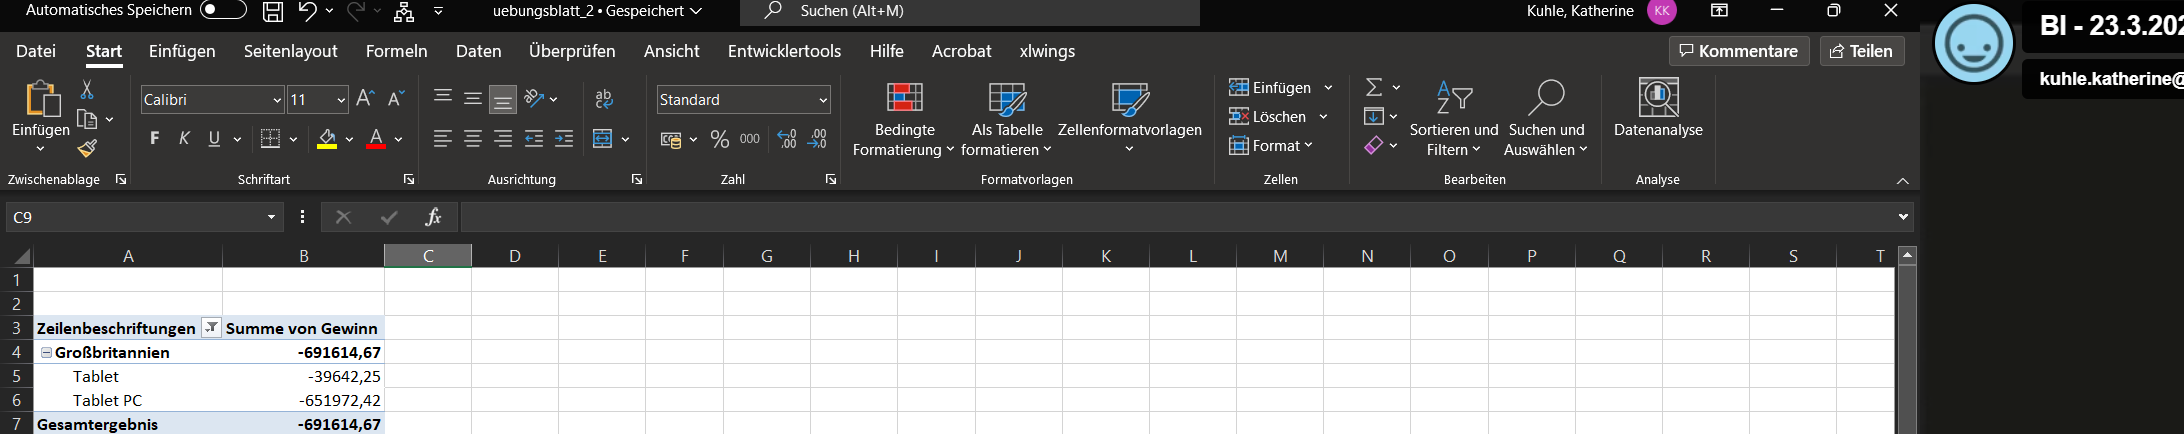

### Aufgabe 2.3
**Eure eigene Fragestellung oder mein Vorschlag ("Von welchen Herstellern wurde insgesamt wie viel umgesetzt?")**

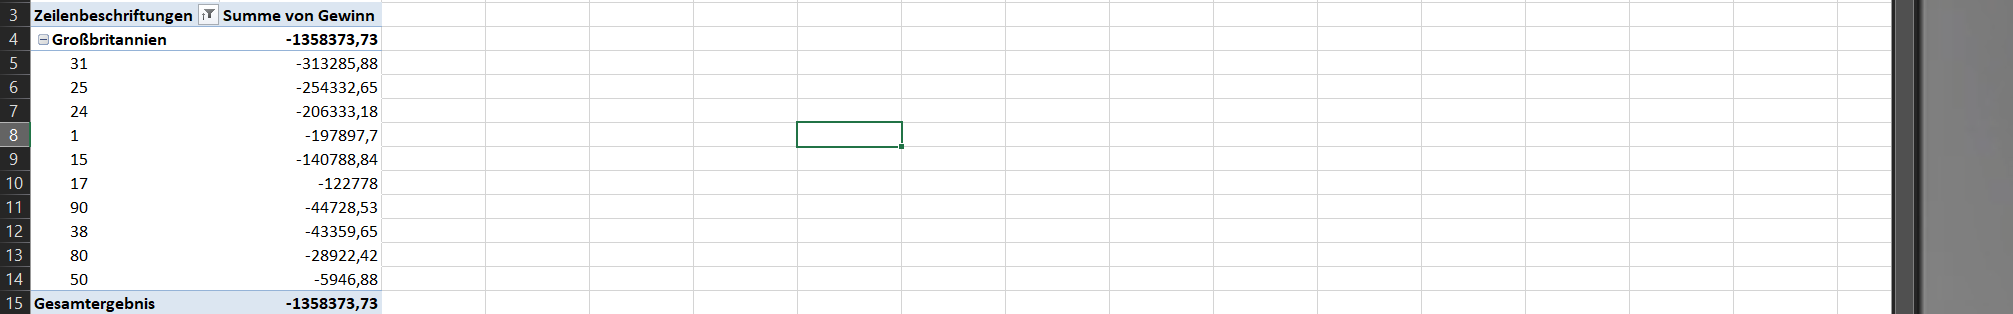

# WICHTIG!
### Bitte reicht auch die Excel-Datei ein, die die einzelnen Pivot Tabellen auf jeweils einem Excel Tabellenblatt beinhaltet
#### Name der abgebenen Exceldatei, die die Pivot Tabellen beinhaltet: 

`ÜB2_Lösung_Studierendenname.xlsx`

# Aufgabe 3
**Pivot Tabellen von oben (Excel) in Python via Pandas umsetzen**

> Lade die Tabelle `Aufgabe1_daten.csv` in ein Pandas DataFrame und führe die in Excel ausgeführten OLAP Funktionen analog in Python aus.

In [9]:
df_PCPowerMarkt = pd.read_csv("data/Aufgabe1_daten.csv", sep=";", decimal=",", index_col=0, 
                             dtype={
                                'Umsatz Ist': 'float32',
                                'Umsatz Soll': 'float32',
                                'Preis Pro Einheit': 'float32',
                                'Waehrung': 'string',
                                'Kurztext': 'string',
                                'Langtext': "string",
                                'Produktkategorie': 'string',
                                'Hersteller': 'string',
                                'Produktkategorie': 'string',
                                'Produktkategorie': 'string',
                                'Einheit': 'string',
                                'Filiale-Bez': 'string',
                                'Verkaufsleiter': 'string',
                                'Anschrift': 'string',
                                'Filiale-PLZ': 'string',
                                'Filiale-Ort': 'string',                               
                                'Region': 'string',
                                'Region-Bez': 'string',
                                'Land': 'string',
                                'LandBez': 'string',
                                'Bezeichnung': 'string',
                                'Medienart': 'string',
                                'Verantwortlicher': 'string',
                                'KalMonatJahr': 'string',
                                'Monat': 'string',
                             })



## Beispiel

In [10]:
df_pivot_beispiel = pd.pivot_table(
    df_PCPowerMarkt,
    values=['Umsatz Ist', 'Umsatz Soll'],
    index=['Waehrung', 'LandBez'],
    aggfunc=np.sum
    )
display(df_pivot_beispiel)

Umsatz Ist  Umsatz Soll
Waehrung LandBez                                 
CAD      Kanada           62781968.0   63277852.0
CHF      Schweiz          39048976.0   38695908.0
DKK      Dänemark        325200992.0  328575328.0
EUR      Belgien          20394028.0   20565188.0
         Deutschland     265841024.0  266301152.0
         Finnland         23106586.0   23077226.0
         Frankreich       21821336.0   21910184.0
         Irland           12813939.0   12912657.0
         Italien          18228290.0   18206736.0
         Spanien          30676048.0   30399152.0
         Österreich       35221092.0   35442796.0
GBP      Großbritannien   11301620.0   11341017.0
NOK      Norwegen         47821764.0   47554196.0
PLN      Polen            85469352.0   85670744.0
SEK      Schweden         98238072.0   97905560.0
USD      USA              28862592.0   28653558.0

### Aufgabe 3.1

In [11]:
#Lösung Ramzan
df_31 = pd.pivot_table(
    df_PCPowerMarkt[
    (df_PCPowerMarkt.LandBez=='Deutschland') &
    (df_PCPowerMarkt.Monat == 'März')],
    values = ['Gewinn'],
    index = ['LandBez', 'Filiale-Bez', 'Monat'],
    aggfunc=np.sum)
df_31

Gewinn
LandBez     Filiale-Bez                              Monat            
Deutschland Global Computer Suppliers-Berlin         März   1226575.56
            Global Computer Suppliers-Frankfurt a.M. März   1340588.80
            Global Computer Suppliers-München        März   1421986.22
            Global Computer Suppliers-Stuttgart      März   1637243.83

### Aufgabe 3.2

In [12]:
# Lösung Tom
df_32 = df_PCPowerMarkt.loc[:,['LandBez', 'Produktkategorie', 'Gewinn']]
df_32 = df_32.groupby(['LandBez', 'Produktkategorie'], as_index=True).sum()
df_32.loc[df_32['Gewinn'] < 0]

Gewinn
LandBez        Produktkategorie           
Großbritannien Tablet            -39642.25
               Tablet PC        -651972.42

### Aufgabe 3.3

In [13]:
df_33 = pd.pivot_table(
    df_PCPowerMarkt[
    df_PCPowerMarkt['LandBez'] == 'Großbritannien']
    [df_PCPowerMarkt['Gewinn'] < 0],
        values='Gewinn',
        index='ProduktID',
        aggfunc=np.sum
        )
df_33.sort_values(by='Gewinn', ascending=True)

C:\Users\kuhle\AppData\Local\Temp\ipykernel_12404\2431090136.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_PCPowerMarkt[


,Gewinn
ProduktID,
31,-313285.88
25,-254332.65
24,-206333.18
1,-197897.70
15,-140788.84
17,-122778.00
90,-44728.53
38,-43359.65
80,-28922.42
